# Static Mapping

This notebook provides more detail on using `marketmaps` for deriving static market maps.  

For a more condensed overview, see <a href = 'car application.html'>the car example</a>. 

## Sections

1. [Loading the Data](#section_1)

2. [Mapping the Data](#section_2)

3. [Exploring the Map](#section_3)

4. [Evaluating the Map](#section_4)

## Background

The methods used herein are based on the following papers. If you use them, please cite these authors' work. 
```
**add references**
```


**Author:** Maximlian Matthe (matthe@wiwi.uni-frankfurt.de)

**Last updated:** May 2022

<a id = 'section_1'></a>
## Loading the Data
First, lead all required imports for this demonstration and set the seed to ensure reproducibility. 

In [1]:
import pandas as pd
import numpy as np
import os
np.random.seed(123) 

For this demonstration, we use a sample of the TNIC data also used in [[1]](#ref_1). The original data is provided at https://hobergphillips.tuck.dartmouth.edu/. The data consists of an edgelist, that is, firm-firm relationships. 

In the final data, each row corresponds to a single firm-firm pair at a specific point in time. Thus, each firm variable appears twice in each row (once for each firm). We provide the merged data on our website, from which you can directly and store it. 

In [2]:
from marketmaps.datasets import load_tnic_snapshot
tnic_snapshot = load_tnic_snapshot()
sim_mat = tnic_snapshot['matrix']
labels = tnic_snapshot['labels']
cluster = tnic_snapshot['cluster']

This snapshot includes roughly 1,000 firms such as:

In [3]:
labels[:10]

array(['AMERICAN AIRLINES GROUP INC', 'AARONS HOLDINGS COMPANY INC',
       'ABBOTT LABORATORIES', 'AETNA INC', 'AIR T INC',
       'ALASKA AIR GROUP INC', 'MATSON INC', "ALEXANDER'S INC",
       'HONEYWELL INTERNATIONAL INC', 'SKYWORKS SOLUTIONS INC'],
      dtype='<U28')

For each (firm, firm) pair these data include a measure of pairwise similarity: 

In [4]:
sim_mat[:10, :10].round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.04, 0.09, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.04, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.09, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

<a id = 'section_2'></a>
## Mapping the Data

As of now, `marketmaps` implements the following (static) mapping methods:

- Classic Multidimensional Scaling (CMDS)  
- Sammong Mapping
- Visualization of Similarities (VOS)  
- t-SNE 

Running these methods follows the typical 'scikit-learn' conventions (fit / transform / fit_transform), for instance

```
output = CMDS().fit_transform(D)
```

where `D` is supposed to be a data matrix (here: a matrix of pairwise distances). 

In some cases, you might need to transform your data according to the method you want to use. Here, we transform the TNIC data (which represent pariwise similarities) into pairwise distances: 

In [6]:
from marketmaps.preprocessing import sim2dist
D = sim2dist(sim_mat, transformation= 'inverse', eps = 1e-4) 


epoch = 1 : E = 10725.8733777013
epoch = 2 : E = 2432.4582521183
epoch = 3 : E = 170.3440894562
epoch = 4 : E = 70.2583683987
epoch = 5 : E = 19.1651336375
epoch = 6 : E = 9.0044593125
epoch = 7 : E = 4.7308760668
epoch = 8 : E = 2.7768187446
epoch = 9 : E = 1.8314730888
epoch = 10 : E = 1.3453753229
epoch = 11 : E = 1.0752186896
epoch = 12 : E = 0.9144735232
epoch = 13 : E = 0.8119798675
epoch = 14 : E = 0.7424426038
epoch = 15 : E = 0.6924375472
epoch = 16 : E = 0.6549356232
epoch = 17 : E = 0.6256994141
epoch = 18 : E = 0.6020287471
epoch = 19 : E = 0.5823318078
epoch = 20 : E = 0.5659167038
epoch = 21 : E = 0.5513821518
epoch = 22 : E = 0.5383601968
epoch = 23 : E = 0.5270751264
epoch = 24 : E = 0.5263584324
epoch = 25 : E = 0.5159585875
epoch = 26 : E = 0.5071477779
epoch = 27 : E = 0.4997374718
epoch = 28 : E = 0.4922122862
epoch = 29 : E = 0.4862251650
epoch = 30 : E = 0.4800350167
epoch = 31 : E = 0.4747583110
epoch = 32 : E = 0.4701028083
epoch = 33 : E = 0.4656708836
epoch = 

Having transformed the data, we can map them (e.g., via Sammon Mapping):

In [ ]:
from marketmaps.mapping.sammon import sammon
Y, e = sammon(D, n = 2, inputdist= 'distance', maxiter= 150)

As a result, we obtain an array of map coordinates which we can use to draw the map. 

<a id = 'section_3'></a>
## Exploring the Map

To create a map, `marketmaps.printer` provides the `draw_map` function. It provides lots of flexibility to adjust the resultant map's aesthetics.

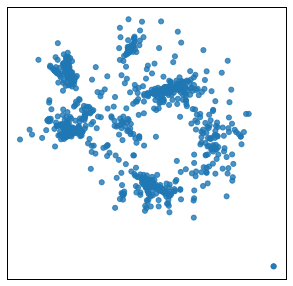

In [7]:
from marketmaps.printer import draw_map
map = draw_map(Y)

Aesthetics of the map can easily be adjusted via additional arguments. For instance, if class labels are available (e.g., obtained via clustering or additional metadata), they can be added as colors. Here, we can use SIC codes for coloring:

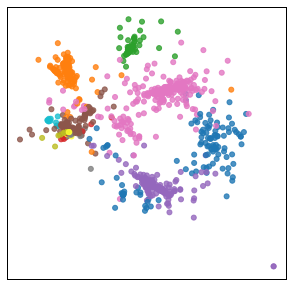

In [8]:
map = draw_map(Y, c = cluster)

One can further annotate the map, using clusters

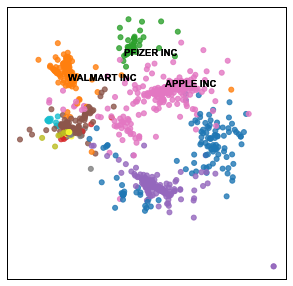

In [9]:
map = draw_map(
    Y, 
    c = cluster, 
    labels = labels, 
    highlight_labels= ['APPLE INC', 'WALMART INC', 'PFIZER INC'])

Note that one can also use additional keyword arguments to adjust the plot and its labels further. 

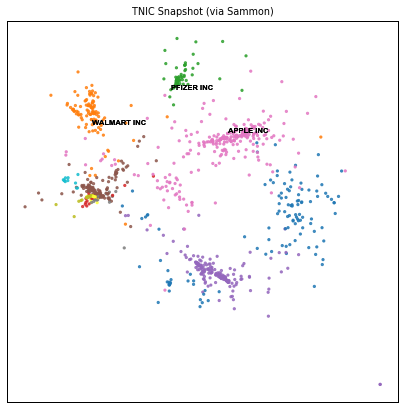

In [10]:
map = draw_map(
    Y, 
    c = cluster, 
    size = 10,
    labels = labels, 
    title_str = 'TNIC Snapshot (via Sammon)',
    fontdict= {'family': 'Arial', 'size': 8},
    highlight_labels= ['APPLE INC', 'WALMART INC', 'PFIZER INC'],
    fig_size= (7,7))

<a id = 'section_4'></a>
## Evaluating the Map

In [11]:
from marketmaps.metrics import hitrate_score
hitrate_score(sim_mat, Y, n_neighbors= 10, input_type= 'similarity')

0.2413919413919414

Let's compare the result to two other methods to generate the map.

Classic Multidimensional Scaling (CMDS):

In [12]:
from marketmaps.mapping import CMDS
Y_CMDS = CMDS().fit_transform(D)

t-distributed Stochastic Neighborhood Embedding (t-SNE):

In [13]:
from marketmaps.mapping import EvoTSNE
Y_tsne = EvoTSNE(weighted = None, input_type= 'distance').fit_transform([D])[0]

Compare how well they perform:

In [17]:
display("CMDS Hitrate: {0:.2f}".format(hitrate_score(D, Y_CMDS, n_neighbors=10, input_type='distance')))
display("Sammon Hitrate: {0:.2f}".format(hitrate_score(D, Y, n_neighbors=10, input_type='distance')))
display("t-SNE Hitrate: {0:.2f}".format(hitrate_score(D, Y_tsne, n_neighbors=10, input_type='distance')))

'CMDS Hitrate: 0.11'

'Sammon Hitrate: 0.24'

't-SNE Hitrate: 0.51'

These differences in solution quality also become apparent when looking at the map output:

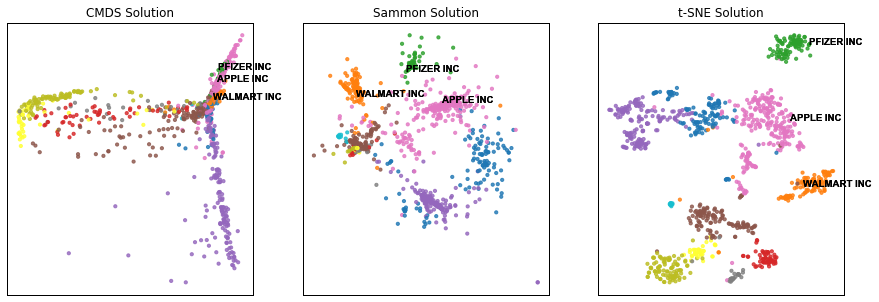

In [25]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,3, figsize = (15, 5))

draw_map(
    Y_CMDS, 
    title_str= 'CMDS Solution', 
    c = cluster,
    labels = labels,
    highlight_labels=['APPLE INC', 'WALMART INC', 'PFIZER INC'], 
    size = 10, 
    ax = ax[0])

draw_map(
    Y, 
    title_str= 'Sammon Solution',
    labels = labels, 
    highlight_labels= ['APPLE INC', 'WALMART INC', 'PFIZER INC'],
    c = cluster,  
    size = 10, 
    ax = ax[1])

draw_map(
    Y_tsne, 
    title_str= 't-SNE Solution',
    labels = labels,
    highlight_labels=['APPLE INC', 'WALMART INC', 'PFIZER INC'],
    c = cluster, 
    size = 10, 
    ax = ax[2])